In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
from numpy import genfromtxt
import random

%matplotlib inline

In [2]:
def zero_pad(X, xsize, ysize):
    """
    Função para adicionar extensão por zeros na imagem de entrada.
    Parametro: X - imagem de entrada
    Retorno: X_pad - imagem resultante da extensão por zeros. 
    """
    h = X.shape[0]
    w = X.shape[1]
    if len(X.shape) == 3:
        z = X.shape[2]
        X_pad = np.concatenate((np.array([[[0]*h]*xsize]*z).T,X), axis=1)
        X_pad = np.concatenate((X_pad,np.array([[[0]*h]*xsize]*z).T), axis=1)
        X_pad = np.concatenate((X_pad,np.array([np.array([[0]*(w+2*xsize)]*ysize).T]*z).T), axis=0)
        X_pad = np.concatenate((np.array([np.array([[0]*(w+2*xsize)]*ysize).T]*z).T,X_pad), axis=0)
    else:
        X_pad = np.concatenate(([[0]*w]*xsize,X), axis=0)
        X_pad = np.concatenate((X_pad,[[0]*w]*xsize), axis=0)
        X_pad = np.concatenate((X_pad,np.array([[0]*(h+2*xsize)]*ysize).T), axis=1)
        X_pad = np.concatenate((np.array([[0]*(h+2*xsize)]*ysize).T,X_pad), axis=1)
   
    return X_pad

In [51]:
def convolution(X,kernel,stride=1, padding=False):
    """
    Função para implementar a operação de convolução.
    Parametros: X - imagem de entrada
                kernel - matriz com o kernel a ser utilizado pela operação
                stride - tamanho do passo a ser utilizado (default 1)
                padding - flag para utilização de padding (default True)
    retorno out_conv: matriz resultante da operação de convolução
    """
    #kernel = np.flip(np.flip(kernel,1),0)
    #print((kernel*X.shape[2])[0])
    x = X.copy()
    rx = kernel.shape[0]//2
    ry = kernel.shape[1]//2
    if padding:
        x = zero_pad(x, rx, ry)
    if len(X.shape) == 3:
        if len(kernel.shape) == 3:
            out = [[np.sum(x[i-rx:i+rx+1, j-ry:j+ry+1]*kernel)
                for j in range(ry, x.shape[1]-ry, stride)] 
                   for i in range(rx, x.shape[0]-rx, stride)]
        else:
            out = [[np.sum(np.sum(x[i-rx:i+rx+1, j-ry:j+ry+1], axis=2)*kernel)
                for j in range(ry, x.shape[1]-ry, stride)] 
                   for i in range(rx, x.shape[0]-rx, stride)]
    else:
        out = [[np.sum(x[i-rx:i+rx+1, j-ry:j+ry+1]*(kernel)) 
                for i in range(ry, x.shape[1]-ry, stride)] 
                   for j in range(rx, x.shape[0]-rx, stride)]
        
    return out

In [4]:
def activation_func(func_type, z):
    """
    Função que implementa as funções de ativação ReLU e Tanh
    Parãmetros: func_type - uma string que contém a função de ativação desejada
                z - matriz resultante da convolução e do bias.
    Retorna: feature map
    """
    ### Seu código aqui (~2 linhas)
    if func_type == 'relu':
        return np.fmax(0,z)
    elif func_type == 'tanh':
        return np.tanh(z)

In [5]:
def visualize_fmap(X):
    """
    Função que convertendo-o para uma imagem em níveis de cinza no intervalo [0, 255], 
    com a) níveis em valor absoluto com preto = zero; e b) mínimo = preto.
    """
    x = X.copy()
    x = np.abs(x) 
    x = np.array(x*255/x.max()).astype('uint8')
    plt.imshow(x, 'gray')
    plt.show()

In [49]:
def convLayer(X,act_func, filters, bias, stride=1, padding=False):
    """
    Implementa a camada convolucional utilizando bias e função de ativação.
    Parametros: X - matriz de entrada
                C - quantidade de canais do feature map
                filters - filtros utilizados na camada
                stride - tamanho do passo a ser utilizado (default 1)
                padding - flag para utilização de padding (default True)
    Retorno: fmap - feature map de dimensão (n_W,n_H, C)
    """
    fmap = np.array([convolution(X,f,stride,padding) for f in filters])
    fmap = np.array([activation_func(act_func, f + b) for f,b in zip(fmap, bias)])
    return fmap

In [31]:
def readFile(file):
    f = open(file, "r")
    size = np.array(f.readline().strip().split(',')).astype('int')
    aux = [i.strip() for i in f.readlines() if i is not "\n"]
    bias = np.array(aux[-1].split(',')).astype('double')
    del aux[-1]
    kernels = np.array([np.array(i.split(',')).astype('double').reshape(size) for i in aux])
    kernels.shape
    return kernels, bias

In [71]:
def maxPooling(x):
    if len(x.shape) < 3:
        out = [[np.max(x[i-1:i+2, j-1:j+2])
                for j in range(1, x.shape[1], 2)] 
                   for i in range(1, x.shape[0], 2)]
    else:
        out = [[[np.max(k[i-1:i+2, j-1:j+2])
                for j in range(1, k.shape[1], 2)] 
                   for i in range(1, k.shape[0], 2)] 
                       for k in x]
    return np.array(out)

In [9]:
def main(file, img):
    convFilters, bias = readFile(file)
    stride = int(input("Entre com um valor inteiro positivo para o stride "))
    padding = (input("Sua operaçao será feita com padding? True or False "))
    imageFile = np.asarray(Image.open(img))
    plt.imshow(imageFile) 
    plt.show()
    fmap = convLayer(imageFile,'relu', convFilters, bias, stride, padding)
    for f in fmap:
        visualize_fmap(f)
    #fmap2 = fmap.swapaxes(0,2).swapaxes(0,1)
    #fmap2 = convLayer(fmap2,'relu', convFilters, bias, stride, padding)
    #print("-"*80)
    #for f in fmap2:
       # visualize_fmap(f)


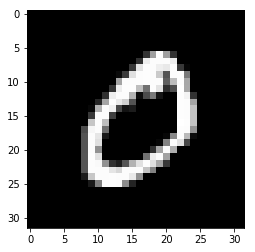

(16, 16)


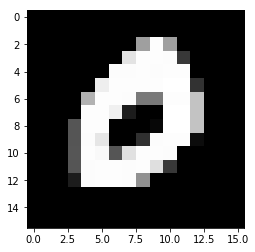

In [72]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = np.array([zero_pad(x,2,2) for x in x_train])
x_test = np.array([zero_pad(x,2,2) for x in x_test])
plt.imshow(x_train[1], 'gray') 
plt.show()
print(maxPooling(x_train[1]).shape)
plt.imshow(maxPooling(x_train[1]),'gray')
plt.show()

In [142]:
# He
sizes = [(5,5), (5,5,6), (5,5,16), (120), (84), (10)]
l = [6,16,120,120,84,10]

kernel0 = np.array(
    [np.sqrt(2) * np.random.randn(sizes[0][0],sizes[0][1]) 
           for _ in range(l[0])])
kernel1 = np.array(
    [np.sqrt(2/l[0]) * np.random.randn(sizes[1][0],sizes[1][1],sizes[1][2]) 
           for _ in range(l[1])])
kernel2 = np.array(
    [np.sqrt(2/l[1]) * np.random.randn(sizes[2][0],sizes[2][1],sizes[2][2]) 
           for _ in range(l[2])])
kernel3 = np.sqrt(2/l[2]) * np.random.randn(sizes[3]) 
kernel4 = np.sqrt(2/l[3]) * np.random.randn(sizes[4]) 
kernel5 = np.sqrt(2/l[4]) * np.random.randn(sizes[5]) 

kernels = (kernel0, kernel1, kernel2, kernel3, kernel4, kernel5)

In [148]:
def softMax(x):
    import bigfloat
    xexp = np.array([bigfloat.exp(i,bigfloat.precision(100)) for i in x])
    return np.exp(x) / np.sum(np.exp(xexp))

In [146]:
fmap = convLayer(x_train[1],'relu', kernels[0], [random.random() for _ in range(l[0])])
fmap = maxPooling(fmap).swapaxes(0,2).swapaxes(0,1)
fmap = convLayer(fmap,'relu', kernels[1], [random.random() for _ in range(l[1])])
fmap = maxPooling(fmap).swapaxes(0,2).swapaxes(0,1)
fmap = convLayer(fmap,'relu', kernels[2], [random.random() for _ in range(l[2])])
fmap = np.array([np.sum(fmap*k) for k in kernels[3]])
fmap = np.array([np.sum(fmap*k) for k in kernels[4]])
fmap = np.array([np.sum(fmap*k) for k in kernels[5]])
softMax(fmap)


ModuleNotFoundError: No module named 'bigfloat'